# *Chandra* results for Osase's SDSS 1531 Paper 

## 0. A summary of how these data products were created: 

G. Tremblay made these for Osase using the *Chandra Cluster Cosmology Project IV* codes from Tremblay & Vikhlinin et al. 2022 in prep. These codes can be a hugely complex spaghetti-ball of 60+ individual perl and python scripts, and so it's far easier to have me reduce and run the data than have Osase do it. For the record, these are the CCPIV codebase commands I used to reduce Osase's data. Osase: I'm happy to explain all of this, and even help you install it on your path_to_beads - but trust me, it's just not worth the pain right now, all we really need is a good Temperature and surface brightness profile. CCCPIV does this with *far* greater care than e.g. the CIAO thread explaining how to obtain and fit a radial SB profile.  

```
Working in ~/100/Osase_Cluster/SDSS1531

Create cluster.par with these contents: 


name = SDSS1531+3414
common_name = SDSSJ1531+3414CLUSTER
useobs = 17218,18689
ra = 15h31m106s
dec = 34d14m25.0s
z = 0.335
nh = 1.79E+20
rax = 232.794243
decx = 34.240245
prof_min_area=0.5

######################
# prof_min_area=0 resulted in a divide by zero error during mk_profiles

cd ~/100/Osase_Cluster

~/100/bin/run_command download_data *
~/100/bin/run_command clone_obsids *
~/100/bin/reduce_cluster --stop_at_lcclean *
~/100/python-scripts/copy_lc_clean_pdfs.py

#On your Desktop, in the lcclean_plots folder, check the results. 


# We see that there is a large flare in 18689, and that lc_clean has done a very poor job of flagging it (it catches the peak and, but not the rise). So let's redo it with AV's script. 

cd SDSS1531

~/100/bin/redo_fi_flare_gti 17218_fi
~/100/bin/redo_fi_flare_gti 18689_fi

~/100/bin/redo_bi_flare_gti 17218_bi
~/100/bin/redo_bi_flare_gti 18689_bi

# clean up the directories 

rm -rf 17218
rm -rf 18689

# the new GTIs have been copied back to 17218_bi, and 18689_bi
# but the FI script doesn't do this, you need to do that manually

mv 17218_fi.save 17218_fi
mv 18689_fi.save 18689_fi

rm -rf 17218_bi_adjgti
rm -rf 17218_fi_adjgti
rm -rf 18689_bi_adjgti
rm -rf 18689_fi_adjgti

cd ..

# I checked the new gti[1-9].fits files, gti1.fits is good in every case

~/100/bin/run_command_on_obsids setup_pad *
#in each process.par, you must update gtifile=gti1.fits
# oops, there's no process.par because do_clean_flares happens just before setup_pad
# just run in manually!


~/100/bin/reduce_cluster --stop_at_lcclean --force_lcclean *
vger &
run_command locate_center *
~/100/bin/reduce_cluster --stop_at_bg *
~/100/bin/run_command_on_obsids examine_bg_norms * # just to look at it again
~/100/bin/run_command_on_obsids check_bg_cal * # nothing is below 0.2, I think we're okay 

~/100/bin/reduce_cluster *

# it worked! We are now done with reduce_cluster

# check the source masks: 

vger &
run_command examine_src_masks *

# look good, no action needed

# Now from the "protocol for analyze_clusters" trello card: 


~/100/bin/run_command setup_bg_regs *
vger &
~/100/bin/run_command mark_bg_regs *


# move the annulus such that it encompasses appropriate local background. It's okay if it goes off the chip a bit

~/100/bin/analyze_cluster --skip_profiles --stop_at_bgfit *

open SDSS1531/spectra/bgfit.pdf

# looks pretty good to me, I'm not sure we need to do any fiddling here, dont see any cluster excess

~/100/bin/analyze_cluster --skip_profiles --stop_at_nh *

open SDSS1531/spectra/nH.pdf
# looks really good to me! 

# now in ~/100/Osase_Cluster/SDSS1531/fitprof
vim fitprof.par
# add this line: 
rmin=1 // kpc

# Now rerun everything up to computing and fitting T- and abundance profiles
cd ~/100/Osase_Cluster
~/100/bin/analyze_cluster --skip_masses --skip_profiles *

open SDSS1531/spectra/Tprof/tprof.pdf

# looks good, BUt has a "step" at the tcool Add this to Tprof/trpof.par
T_acool=1.0
fit_T_acool=no

# Looks great!! 


# FINALLY: 
~/100/bin/analyze_cluster *

# look at the fits in fitprof, etc. 
# copy relevant products for analysis

cp SDSS1531/fitprof/tot.fit.2 /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/spectra/Tprof/tprof.dat /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/spectra/Tprof/tprof.par /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/spectra/Tprof/tprof.rbounds /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles

cp -r SDSS1531/profiles/prof.700-2000.* /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/masses.par /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles


# load profile regions like this: 

vger &
vger -X load SDSS1531/images/ff.img.07-2.gz
vger -X cmap magma
vger -X GaussBlurData, 2.0
vger -X LoadRegions SDSS1531/regs/tprof.reg

or 
vger -X LoadRegions SDSS1531/regs/bg.reg
vger -X LoadRegions SDSS1531/regs/tspec0.reg

```

## 1. Analysis of data products from CCPIV!

In [2]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [1]:
import os
import sys
from types import SimpleNamespace # cute trick to turn dictionaries into separate variables

import numpy as np

from astropy.io import ascii
from astropy.table import Table

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec

#%config InlineBackend.figure_format='retina'

import importlib


In [3]:
#paths
fig_path = path_to_beads + 'Figures/paper/'

In [4]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [11]:
importlib.reload(sf)

<module 'science_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/science_functions.py'>

In [5]:
#pf.styleplots(labelsizes=15)

#### Set up cosmology

In [7]:
z = sf.sdss1531_dict['z'] # best redshift for SDSS 1531
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.335, we have 4.7998 kpc / arcsec


#### Read in Profiles

In [8]:
location_of_vikhlinin_tables = path_to_beads + 'Notebooks/Beads20/Chandra/final_cccp4_profiles/'

In [14]:
#read vikhlinin tprofile fit
tprof_datfile_names = ['Bin', 'T(keV)', 'Terr-', 'Terr+', 'Terr-90percent', 'Terr+90percent', 'Abundance (solar)', 'Abundance_err (solar)', 'nH (1e20 cgs)', 'nH_err (1e20 cgs)', 'T syserr bkg', 'T syserr foregrd', 'G9']
tprof = ascii.read(location_of_vikhlinin_tables + 'tprof.dat', names=tprof_datfile_names)

# This file includes the inner and outer annuli for the temperature profile bins
# you need to include data_end because tprof is usually smaller by a few outer bins
radii_names = ['BIN', 'RIN', 'ROUT']
radii_bounds = ascii.read(location_of_vikhlinin_tables + 'tprof.rbounds', names=radii_names, data_end = len(tprof['Bin']))

# Calclate the bin center from radius
bin_center_radius_kpc = ((radii_bounds['RIN'] + radii_bounds['ROUT']) / 2)* u.arcsec * kpc_per_arcsec
bin_center_radius_err_kpc = ((radii_bounds['ROUT'] - radii_bounds['RIN']) / 2)* u.arcsec * kpc_per_arcsec




In [15]:
#parse temprature, mass and surface brightness profile dictionary

mass_results = sf.parse_mass_parfile(location_of_vikhlinin_tables + 'masses.par')

sbprof_par_dict = sf.parse_sbprof_parfile(location_of_vikhlinin_tables + 'tot.fit.2')
tprof_par_dict = sf.parse_tprof_parfile(location_of_vikhlinin_tables + 'tprof.par')

(sbfitx, sbfity) = sf.vikhlinin_ne_np_fit(sbprof_par_dict)
(tfitx, tfity) = sf.vikhlinin_temperature_fit(tprof_par_dict)


#### Temperature profile & fit

The profile annuli look like this, by the way: 

<img src="final_cccp4_profiles/temperature_profile_regions.png" alt="regions" width="600"/>


Plot the temperature profile, fit, and other relevant metadata (for publication!)

Text(0.5, 0, 'Radius (kpc)')

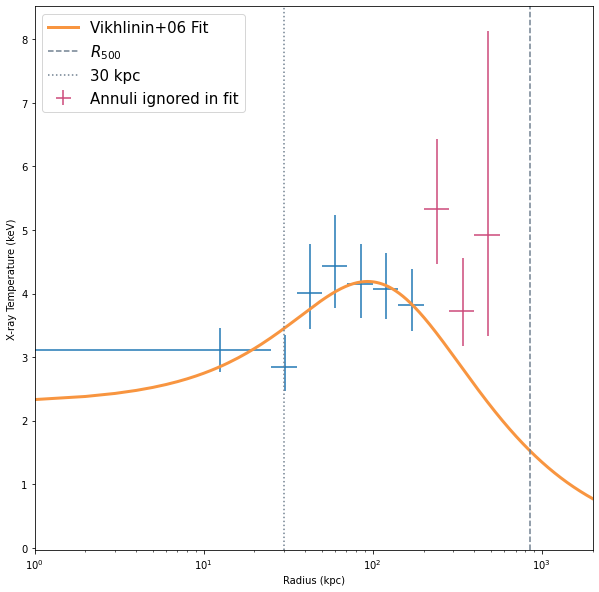

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

# I only fit the temperature profile using data points from the first 7 annuli
last_fit_annulus = 7
last_valid_annulus = len(tprof['T(keV)']) 

colors= sns.color_palette('plasma',3)

ax.errorbar(bin_center_radius_kpc[:last_fit_annulus], tprof['T(keV)'][:last_fit_annulus], 
            yerr=[-tprof['Terr-'][:last_fit_annulus], tprof['Terr+'][:last_fit_annulus]], 
            xerr=bin_center_radius_err_kpc[:last_fit_annulus], ls='none')

ax.errorbar(bin_center_radius_kpc[last_fit_annulus:], tprof['T(keV)'][last_fit_annulus:], 
            yerr=[-tprof['Terr-'][last_fit_annulus:], tprof['Terr+'][last_fit_annulus:]], 
            xerr=bin_center_radius_err_kpc[last_fit_annulus:], ls='none', 
            label='Annuli ignored in fit', color=colors[1])

ax.plot(tfitx,tfity, label='Vikhlinin+06 Fit', color=colors[2], lw=3)
ax.set_xscale('log')
ax.set_xlim(1,2000)

r500 = 848.6 # kpc
ax.axvline(r500, color='slategray', ls='--', label=r'$R_{500}$') # R_500 from the CCCPIV best fit. 
ax.axvline(30, color='slategray', ls=':', lw=1.5, label=r'30 kpc') 

ax.legend(fontsize=15)
ax.set_ylabel('X-ray Temperature (keV)')
ax.set_xlabel('Radius (kpc)')

# fig.savefig(fig_path + 'chandra_tprofile.pdf')

The power emitted per cubic cm per second (i.e., $\mathrm{erg}~\mathrm{s}^{-1}$ $\mathrm{cm}^{-3}$) of a fully ionized plasma emitting "free-free" / thermal bremsstrahlung radiation is given by 

$\epsilon^{ff} \equiv 1.4 \times 10^{-27} T^{1/2} n_e n_i Z^2 \bar{g}_B$,

where $1.4\times10^{-27}$ comes from integrating over the power per unit area per unit frequency (and includes things like the Boltzmann constant, see eq. 1.3 of Cavagnolo's PhD thesis), $n_e$ and $n_i$ are the electrion and ion densities, $Z$ is the number of protons of the bending charge, and $\bar{g}_B$ is the frequency averaged Gaunt factor, and $T$ is the global temperature determined from the spectral cut-off frequency. Because free-free emission is a two-body process, the emission goes as gas density squared and has a weak dependence on the thermal energy, i.e. $\epsilon \propto \rho^2 T^{1/2}$ for $T \geq 10^7$ K. 

Now, look at that equation above. The power emitted is the thing we detect with \textit{Chandra}, essentially. It is directly coupled to fundamentally two properties: temperature and density.

In fact, it directly follows that observing 

$\eta = \frac{10^{-14}}{4\pi D_A^2(1+z)^2} \int n_e n_p dV$

#### Read in the surface brightness profiles (data)

In [18]:

# c2e means "counts to emission measure" - yes, this is bad ambiguous naming and I don't recommend it. 

sb_profile_names = ['RIN', 'ROUT', 'IGNORE1', 'IGNORE2', 'SUR_BRI', 'SUR_BRI_ERR']
c2e_names = ['RIN', 'ROUT', 'R_KPC', 'C2EMM', 'GOV5', 'GOV6', 'GOV7', 'GOV8', 'GOV9', 'GOV10', 'GOV11']

sb_profile_17218_bi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.17218_bi.flat', names=sb_profile_names)
sb_profile_17218_fi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.17218_fi.flat', names=sb_profile_names)
sb_profile_18689_bi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.18689_bi.flat', names=sb_profile_names )
sb_profile_18689_fi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.18689_fi.flat', names=sb_profile_names )

counts2emm_sb_profile_17218_bi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.17218_bi.flat.spec', names=c2e_names)
counts2emm_sb_profile_17218_fi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.17218_fi.flat.spec', names=c2e_names)
counts2emm_sb_profile_18689_bi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.18689_bi.flat.spec', names=c2e_names)
counts2emm_sb_profile_18689_fi = ascii.read(location_of_vikhlinin_tables + 'prof.700-2000.18689_fi.flat.spec', names=c2e_names)

# including the front-illuminated chips, which are WAY outside of the cluster and basically all background

# profiles = [sb_profile_17218_bi, sb_profile_17218_fi, sb_profile_18689_bi, sb_profile_18689_fi]
# c2etables = [counts2emm_sb_profile_17218_bi, counts2emm_sb_profile_17218_fi, counts2emm_sb_profile_18689_bi, counts2emm_sb_profile_18689_fi]

# BI chips only (i.e. the nominal aimpoint )
profiles = [sb_profile_17218_bi, sb_profile_18689_bi]
c2etables = [counts2emm_sb_profile_17218_bi, counts2emm_sb_profile_18689_bi]
obsids = ["ObsID 17218", "ObsID 18689"]




##### Read in the surface brightness profile fit

In [19]:
sb_profile_fit_names = ['R', # radius in kpc, r=(r1+r2)/2 where r1 and r2 are the inner and outer radii of the annulus
                        'FIT', # Emission measure,  E=\int ne np dl, in units of cgs per kpc^2 (sorry :). E.g., you need to divide these numbers by 9.52141e+42 (i.e. kpc^2 in cm) to get to the cgs units. C.f. CCCP2 fig5.
                        'ne_np', # np * ne at radius r (cgs)
                        'sqrt(ne_np)', # sqrt(ne*np) at radius r (cgs units)
                        'outer_annulus_r', #r2 (outer annulus radius) in kpc, cf col 1
                        'gas_mass', # gas mass within r < r2, Msolar
                        'spherical_overdensity'] # Spherical overdensity of the gas mass with respect to the mean cosmic density of baryons.

sb_profile_fit = ascii.read (location_of_vikhlinin_tables + 'tot.fit.2',
                           names = sb_profile_fit_names,
                           data_end=87)

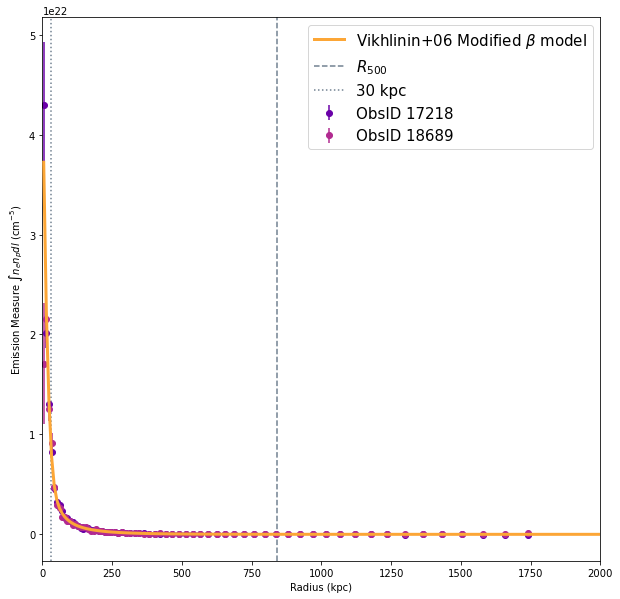

In [20]:
#no log
fig, ax = plt.subplots(figsize=(10,10))

colors= sns.color_palette('plasma',4)

for i, profile in enumerate(profiles):

    x = c2etables[i]['R_KPC']
    y = (profile['SUR_BRI']  * c2etables[i]['C2EMM'] - sbprof_par_dict['bg']) / 9.52141e+42 # this factor is cm2 per kpc2
    err = (profile['SUR_BRI_ERR'] * c2etables[i]['C2EMM']) / 9.52141e+42

    ax.errorbar(x,y, yerr=err, ls='none', marker='o', label=obsids[i], color=colors[i])

sb_fit_x = sb_profile_fit['R'] 
sb_fit_y = sb_profile_fit['FIT']/ 9.52141e+42

    
ax.plot(sb_fit_x, sb_fit_y, lw=3, zorder=3, label=r'Vikhlinin+06 Modified $\beta$ model', color=colors[3])

ax.set_ylabel(r'Emission Measure $\int n_e n_p dl$ (cm$^{-5}$)')
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.
ax.axvline(30, color='slategray', ls=':', lw=1.5, label=r'30 kpc') # R_500 from the CCCPIV best fit.
# ax.set_ylim(1e17,1e23)
ax.set_xlim(0,2e3)
#ax.set_title("Cluster X-ray Surface Brightness Profile \n")

ax.set_xlabel('Radius (kpc)')
ax.legend(fontsize=15)

# fig.savefig(fig_path + 'chandra_sbprofile.pdf')



In [21]:
tprof_pars = tprof_par_dict

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


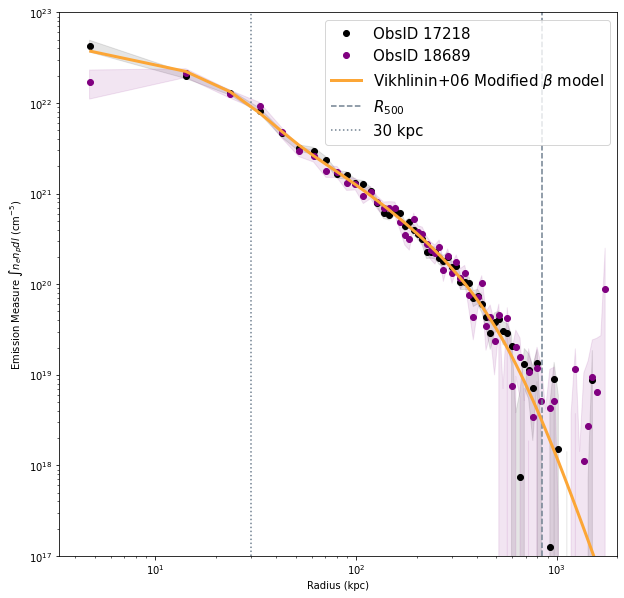

In [22]:
#log-log
fig, ax = plt.subplots(figsize=(10,10))

colors= ['k', 'purple']

for i, profile in enumerate(profiles):

    x = c2etables[i]['R_KPC']
    y = (profile['SUR_BRI']  * c2etables[i]['C2EMM'] - sbprof_par_dict['bg']) / 9.52141e+42 # this factor is cm2 per kpc2
    err = (profile['SUR_BRI_ERR'] * c2etables[i]['C2EMM']) / 9.52141e+42
    
    ax.fill_between(x, y - err, y + err, color=colors[i], alpha = 0.1)
    ax.plot(x, y, c = colors[i], ls='none', marker='o', label=obsids[i])
    #ax.errorbar(x,y, yerr=err, ls='none', marker='o', label=obsids[i], color=colors[i])

sb_fit_x = sb_profile_fit['R'] 
sb_fit_y = sb_profile_fit['FIT']/ 9.52141e+42

colors= sns.color_palette('plasma',4)   
ax.plot(sb_fit_x, sb_fit_y, lw=3, zorder=3, label=r'Vikhlinin+06 Modified $\beta$ model', color=colors[3])

ax.set_ylabel(r'Emission Measure $\int n_e n_p dl$ (cm$^{-5}$)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.
ax.axvline(30, color='slategray', ls=':', lw=1.5, label=r'30 kpc') # R_500 from the CCCPIV best fit.
ax.set_ylim(1e17,1e23)
ax.set_xlim(0,2e3)
#ax.set_title("Cluster X-ray Surface Brightness Profile \n")

ax.set_xlabel('Radius (kpc)')
ax.legend(fontsize=15)

# fig.savefig(fig_path + 'chandra_sbprofile.pdf')



In [55]:
r = sb_fit_x

regrid_tfitx, regrid_tfity = sf.vikhlinin_temperature_fit(tprof_pars, r)
t_kev = regrid_tfity

ne_np = sb_profile_fit['ne_np']
sqrt_ne_np = sb_profile_fit['sqrt(ne_np)']


# Alexey gives us ne * np. To convert this to ne, we assume that 
# ne = sqrt(ne^2) = sqrt(1.199 ne * np) where Z = ne / np = 1.199 is the 
# average nuclear mass for a plasma with 0.3 Zsolar metallicity, assuming abundances 
# from Anders & Grevesse (1989).

# use McDonald Z/3 metallicity values, i.e. 

n_e = np.sqrt(1.199 * ne_np) #  * u.cm**-3
n_p = (1/1.199) * n_e 
n_h = 0.83 * n_e 

pressure_profile = (n_e + n_p) * t_kev # this is correct and has correct units keV / cm3
# pressure_profile_lower_err = (n_e + n_p) * tprof['Terr-']
# pressure_profile_upper_err = (n_e + n_p) * tprof['Terr+']
entropy_profile = t_kev * n_e**(-2/3)
# entropy_profile_lower_err = tprof['Terr-'] * n_e**(-2/3)
# entropy_profile_upper_err = tprof['Terr+'] * n_e**(-2/3)

# (3/2 nkT)/(nenpΛ(T,Z))
cool_func_gunits = coolingFunction(t_kev) * (u.erg * u.cm**3 / u.s) #cgs units

cooling_time = ((3/2 * pressure_profile * (u.keV/u.cm**3)) / (n_e * n_p * u.cm**(-6) * cool_func_gunits)).cgs

In [26]:
def parse_accept_table(accept_table_file):

    accept_table_raw = ascii.read(accept_table_file)

    accept_table_grouped = accept_table_raw.group_by('Name')
    return accept_table_grouped

accept_table = parse_accept_table(profiles_dir + 'accept_main_table.txt')




In [27]:
for cluster_name, cluster_profile in zip(accept_table.groups.keys, accept_table.groups):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    mean_temperature = np.sum(cluster_profile['Tx'])

In [28]:
# underplot the cooling time profiles for all accept clusters as a comparison! 
for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    min_temperature = np.min(cluster_profile['Tx'])


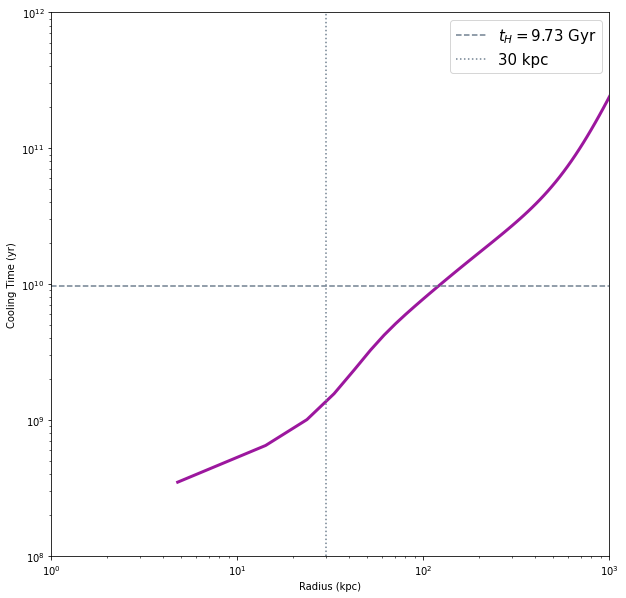

In [56]:
fig, ax = plt.subplots(figsize=(10,10))

colors= sns.color_palette('plasma',2)

ax.plot(r, (cooling_time.to(u.yr)), zorder=2, lw=3, color=colors[0])


n = len(accept_table.groups.keys)
colors = sns.color_palette("Spectral", as_cmap=True)#(np.linspace(0,1,n))

# underplot the cooling time profiles for all accept clusters as a comparison! 
# for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
#     accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
#     min_temperature = np.min(cluster_profile['Tx'])

    

#     ax.plot(accept_radius, cluster_profile['tcool3/2'], zorder=1, alpha=0.4, color=colors[i], lw=1, linestyle='None', marker='o', markersize=0.6)

#ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5) # R_500 from the CCCPIV best fit.


ax.axhline(cosmo.age(z=0.335).value * 1e9, color='slategray', ls='--', lw=1.5, label=r'$t_H = 9.73$ Gyr') # R_500 from the CCCPIV best fit.


ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1, 1000)
ax.set_ylim(1e8, 1e12)

#ax.set_title(r'Cooling Time \n')
ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Cooling Time (yr)')
ax.axvline(30, color='slategray', ls=':', lw=1.5, label=r'30 kpc')

ax.legend(fontsize=15)

# fig.savefig(fig_path + 'chandra_tcool_profile.pdf')



Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


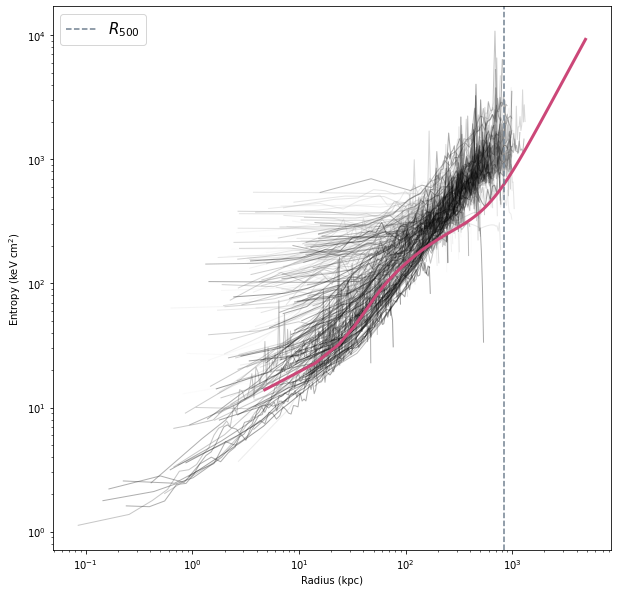

In [31]:
fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(r, cooling_time/ 3.156e+16, zorder=2)

# underplot the cooling time profiles for all accept clusters as a comparison! 
n = len(accept_table.groups.keys)
colors = sns.color_palette("Greys", as_cmap=True)(np.linspace(0,1,n))
for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    mean_temperature = np.sum(cluster_profile['Tx'])


    ax.plot(accept_radius, cluster_profile['Kitpl'], zorder=1, alpha=0.4, color=colors[i], lw=1)
    # print(accept_radius)
    #label=cluster_name,

ax.plot(r, entropy_profile, color=sns.color_palette('plasma',1)[0], lw=3)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(0)
# ax.set_ylim(1, 10)

#ax.set_title(r'Entropy')

ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.


ax.set_xlabel('Radius (kpc)')
ax.set_ylabel('Entropy (keV cm$^2$)')

ax.legend(fontsize=15)

# fig.savefig(fig_path + 'chandra_entropy_profile.pdf')

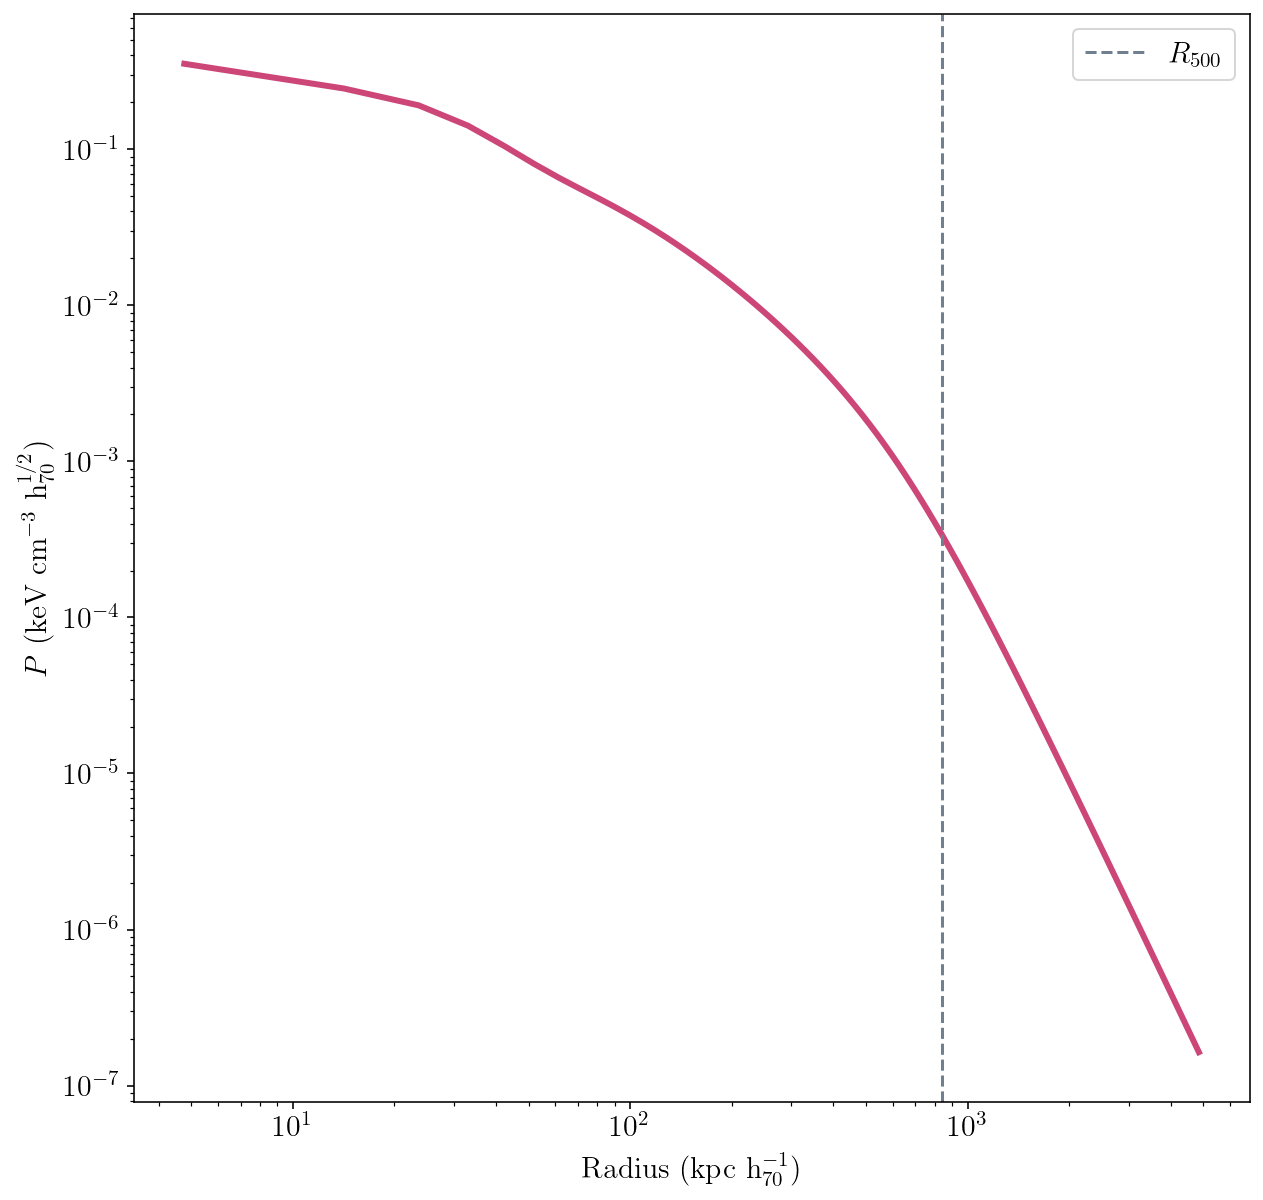

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r, pressure_profile, color=sns.color_palette('plasma',1)[0], lw=3)
ax.set_yscale('log')
ax.set_xscale('log')

ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.
# ax.set_title(r'Pressure Profile ($nkT$)')
ax.set_ylabel(r'$P$ (keV cm$^{-3}$ h$_{70}^{1/2}$)')
ax.set_xlabel(r'Radius (kpc h$_{70}^{-1}$)')

ax.legend(fontsize=15)

# fig.savefig(fig_path + 'chandra_pressure_profile.pdf')

This is consistent with the Arnaud +10 universal pressure profiles 

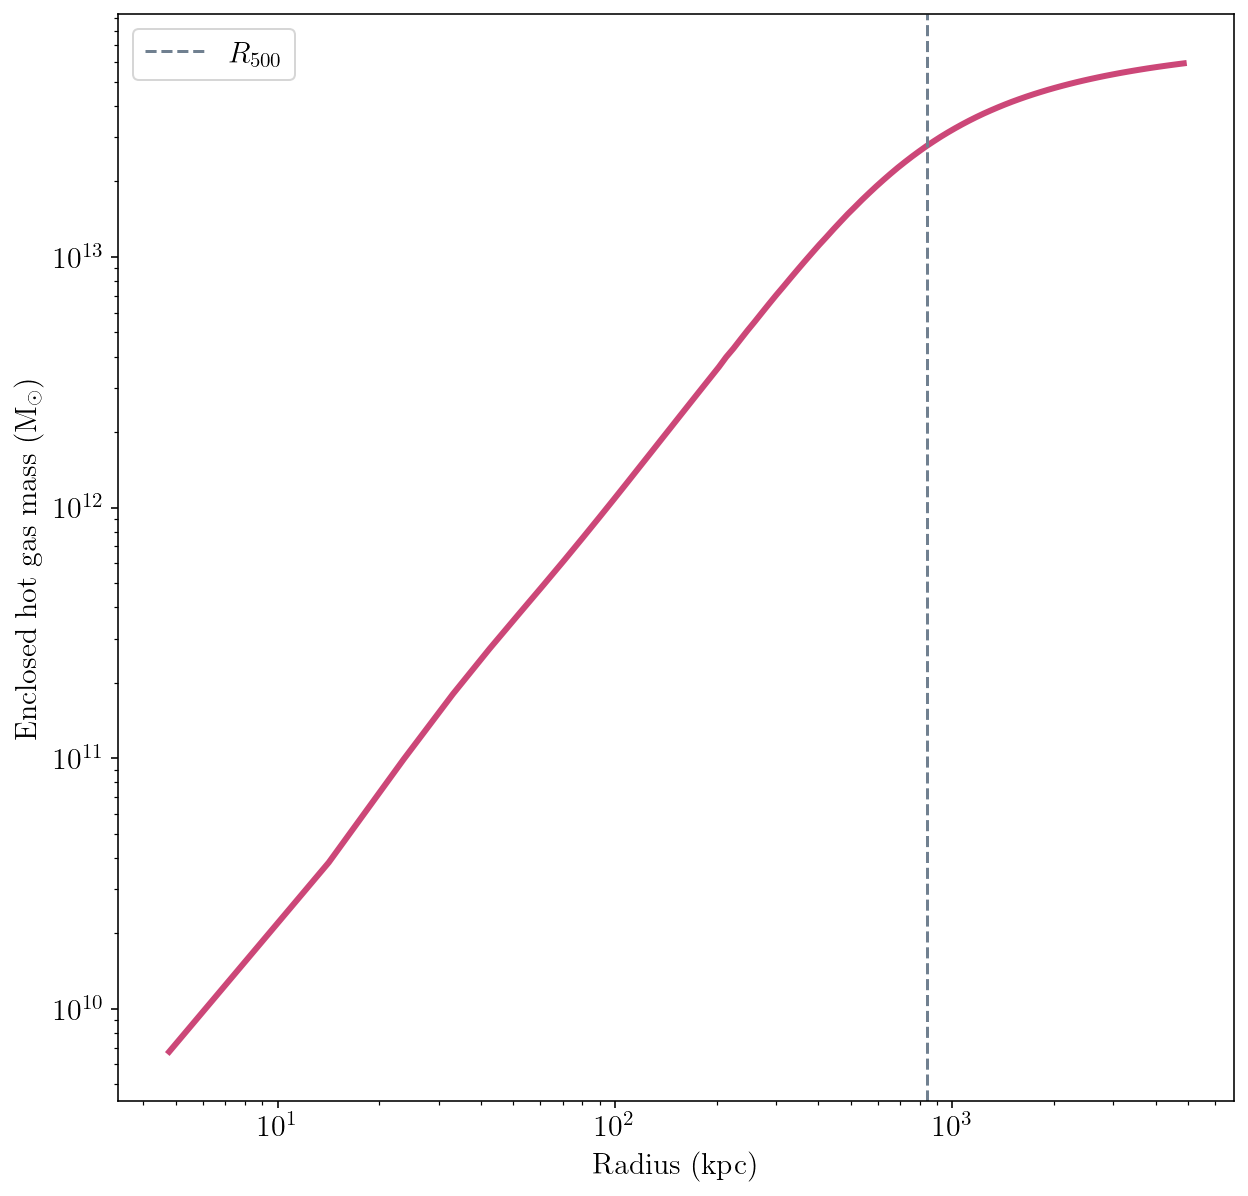

In [50]:
fig, ax = plt.subplots(figsize=(10,10))

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass']

ax.plot(x,y, color=sns.color_palette('plasma',1)[0], lw=3)

ax.set_yscale('log')
ax.set_xscale('log')

ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.


#ax.set_title('ICM gas mass')
ax.set_ylabel(r'Enclosed hot gas mass (M$_{\odot}$)')
ax.set_xlabel(r'Radius (kpc)')

ax.legend(fontsize=15)

# fig.savefig(fig_path + 'chandra_mass_profile.pdf')

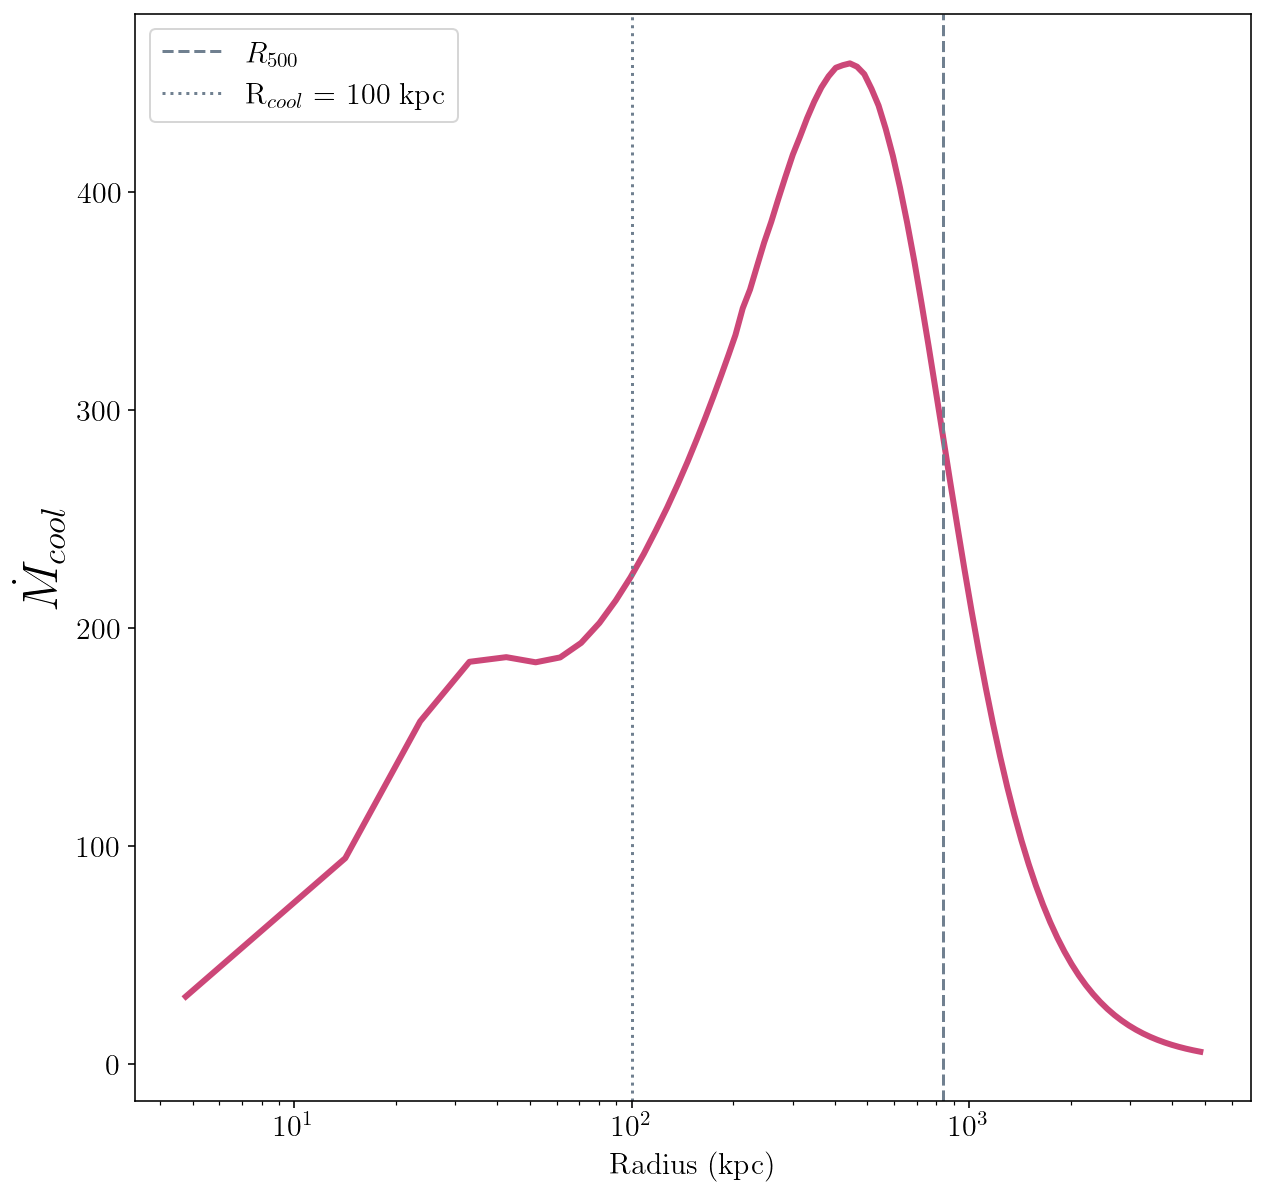

In [51]:
fig, ax = plt.subplots(figsize=(10,10))

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass']

ax.plot(x,y/(cooling_time/ 3.156e+16), color=sns.color_palette('plasma',1)[0], lw=3)

# ax.set_yscale('log')
ax.set_xscale('log')

ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.


#ax.set_title('ICM gas mass')
ax.set_ylabel(r'$\dot{M}_{cool}$', fontsize=25)
ax.set_xlabel(r'Radius (kpc)')

ax.axvline(100, color='slategray', ls=':', lw=1.5, label=r'R$_{cool}$ = 100 kpc')

ax.legend(fontsize=15)


Text(0.5, 0, 'Radius (kpc)')

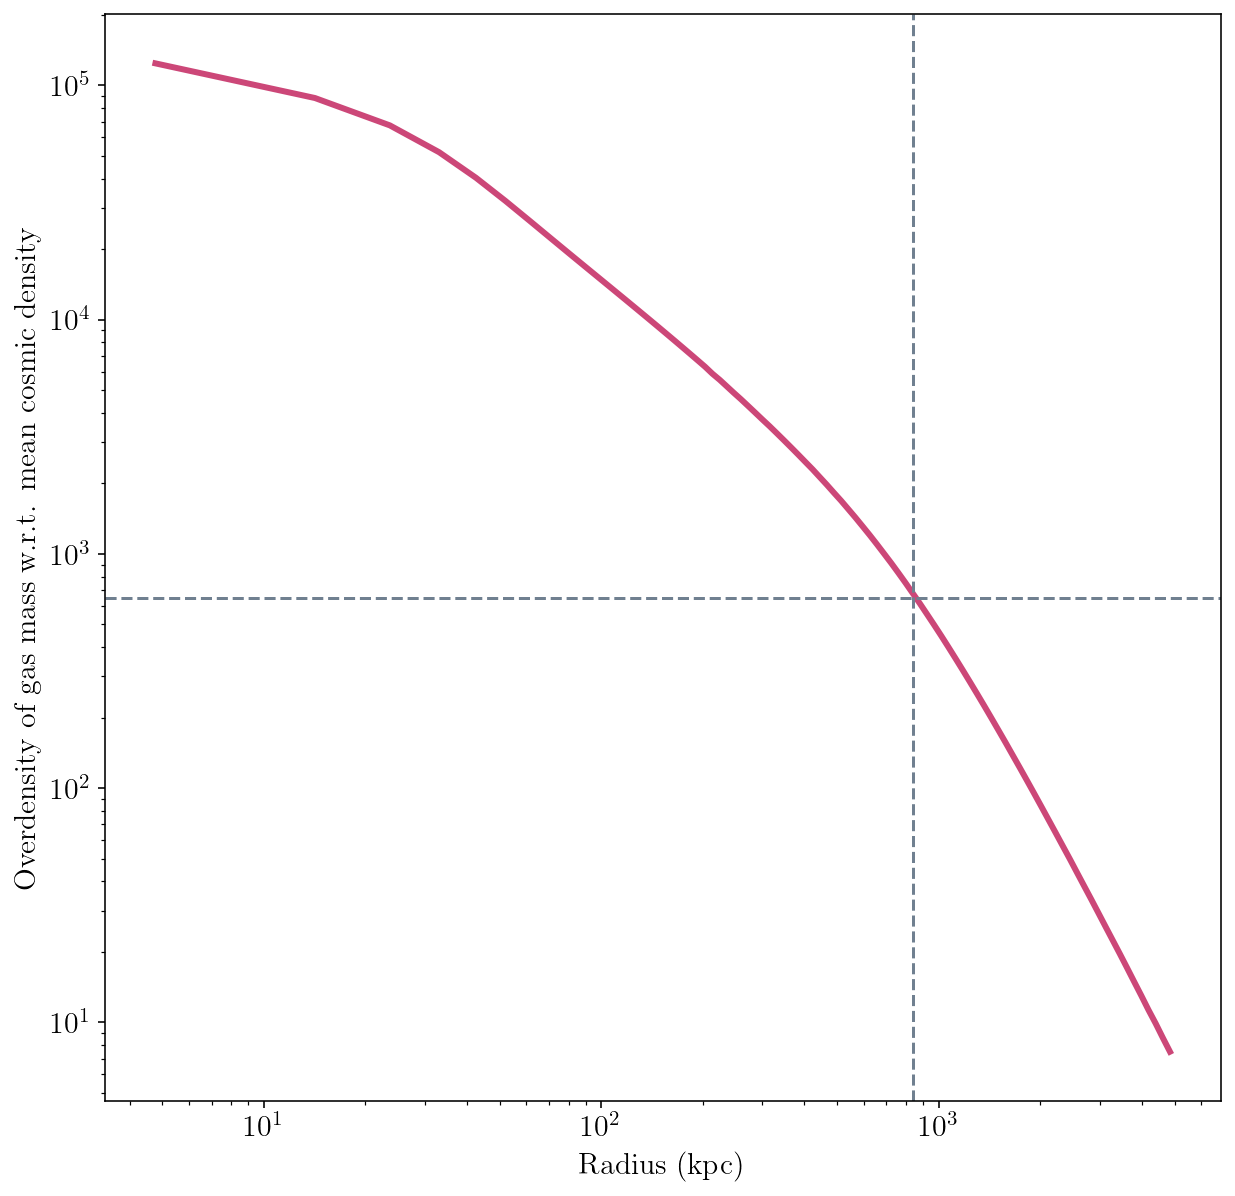

In [52]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r,sb_profile_fit['spherical_overdensity'],color=sns.color_palette('plasma',1)[0], lw=3)

ax.set_yscale('log')
ax.set_xscale('log')

#ax.axvline(950, color='slategray', ls='--', lw=1.5) 
ax.axhline(650,  color='slategray', ls='--', lw=1.5)

ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5) # R_500 from the CCCPIV best fit.


#ax.set_title('Cluster overdensity')
ax.set_ylabel(r'Overdensity of gas mass w.r.t. mean cosmic density')
ax.set_xlabel(r'Radius (kpc)')

## Analysis


### Free-fall time / cooling time ratio

$$ t_{freefall} = \sqrt{\frac{2R^3}{G M}}$$

In [32]:
t_freefall = np.sqrt((2 * np.power(sb_profile_fit['R'] * u.kpc, 3))/
                        (const.G * sb_profile_fit['gas_mass'] * u.solMass)).to(u.Gyr)

Text(0.5, 0, 'Radius (kpc)')

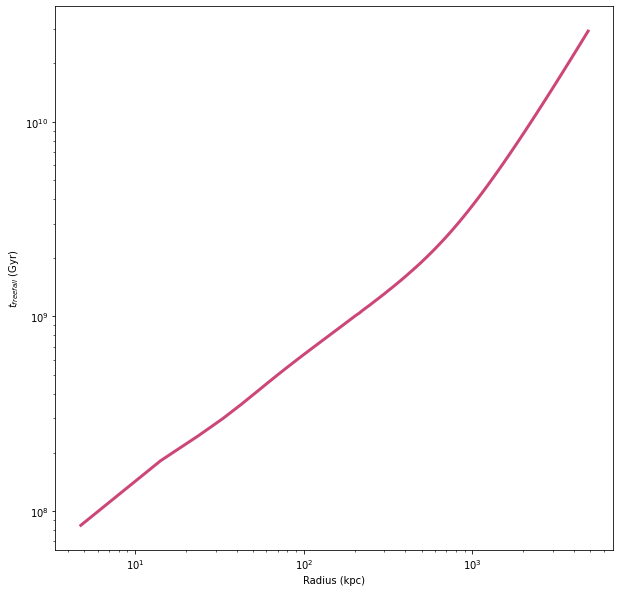

In [33]:
fig, ax = plt.subplots(figsize=(10,10))

ax.loglog(sb_profile_fit['R'], t_freefall.to(u.yr), color=sns.color_palette('plasma',1)[0], lw=3)

ax.set_ylabel(r'$t_{freefall}$ (Gyr)')
ax.set_xlabel(r'Radius (kpc)')

In [36]:
t_freefall.to(u.Gyr)[3]

<Quantity 0.29857807 Gyr>

In [39]:
((cooling_time/ 3.156e+16) * u.yr).to(u.Gyr)[4]/t_freefall.to(u.Gyr)[4]

<Quantity 4.15199156>

Text(0.5, 0, 'Radius (kpc)')

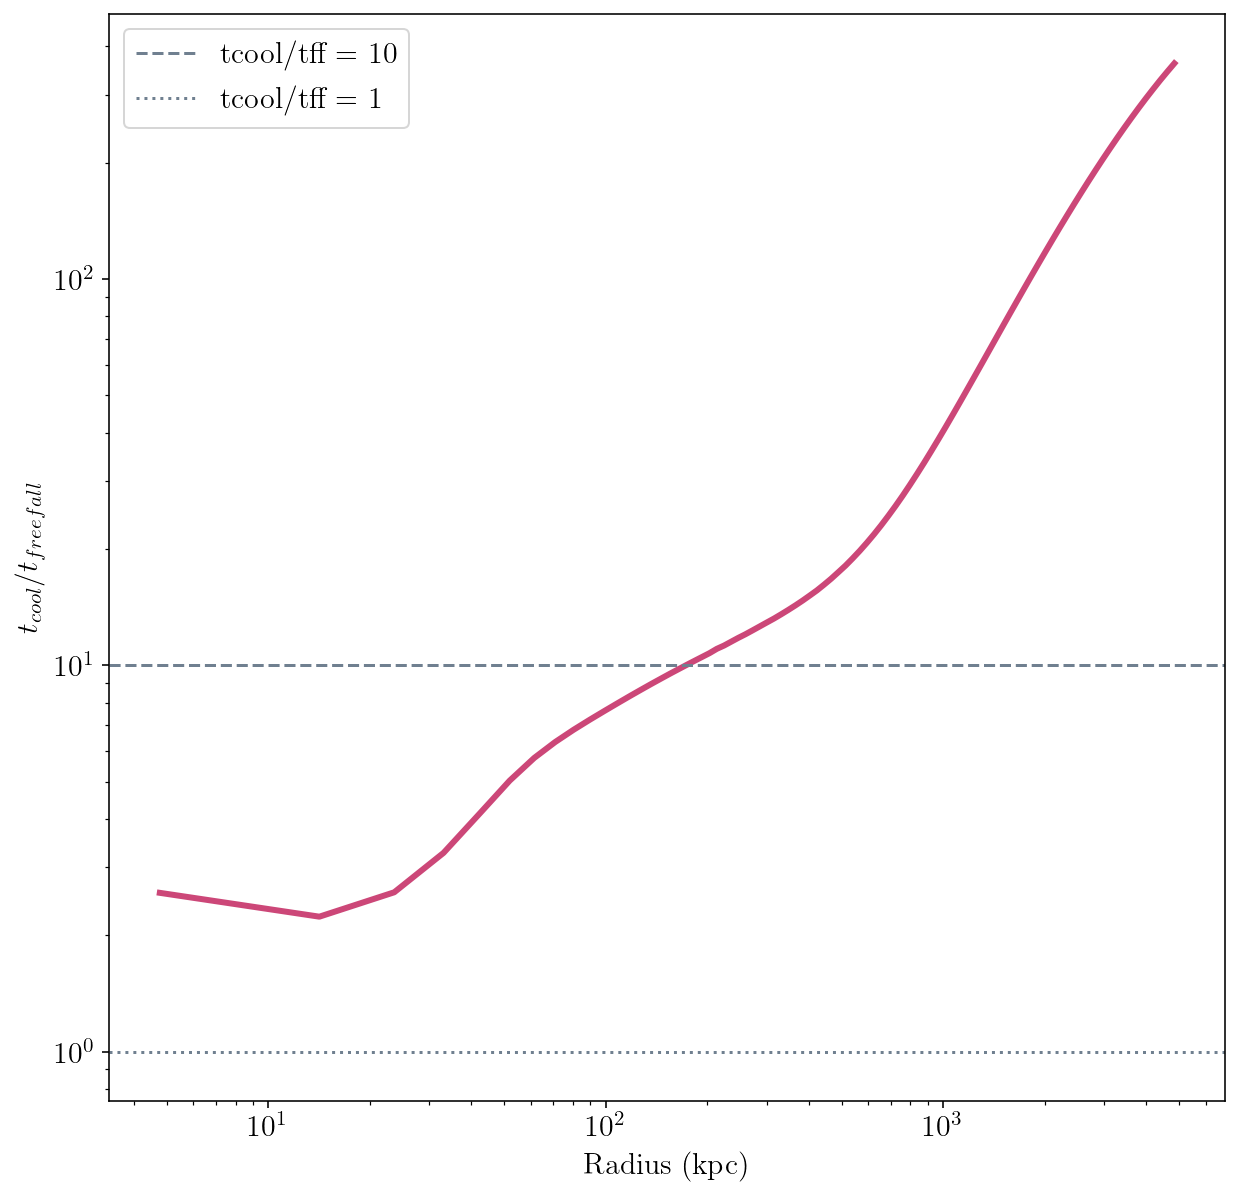

In [55]:
#ratio of tcool/tff. 
# SHould be less than 20 for presence of molecular gas
tcool = ((cooling_time/ 3.156e+16) * u.yr).to(u.Gyr)
tcool_tff_ratio = (tcool/t_freefall).cgs

fig, ax = plt.subplots(figsize=(10,10))

ax.loglog(sb_profile_fit['R'], tcool_tff_ratio, color=sns.color_palette('plasma',1)[0], lw=3)
ax.axhline(10,  color='slategray', ls='--', lw=1.5, label='tcool/tff = 10')
ax.axhline(1,  color='slategray', ls=':', lw=1.5, label='tcool/tff = 1')

ax.legend()
ax.set_ylabel(r'$t_{cool}/t_{freefall}$')
ax.set_xlabel(r'Radius (kpc)')

### Calculate rho_ICM

In [56]:
picm = ((y[3] * u.solMass)/((4 * np.pi/3) * (x[3] * u.kpc)**3)).to(u.g/(u.cm)**3)

### Put all profiles together

In [38]:
pf.styleplots(labelsizes=18, ticksizes=15)

Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


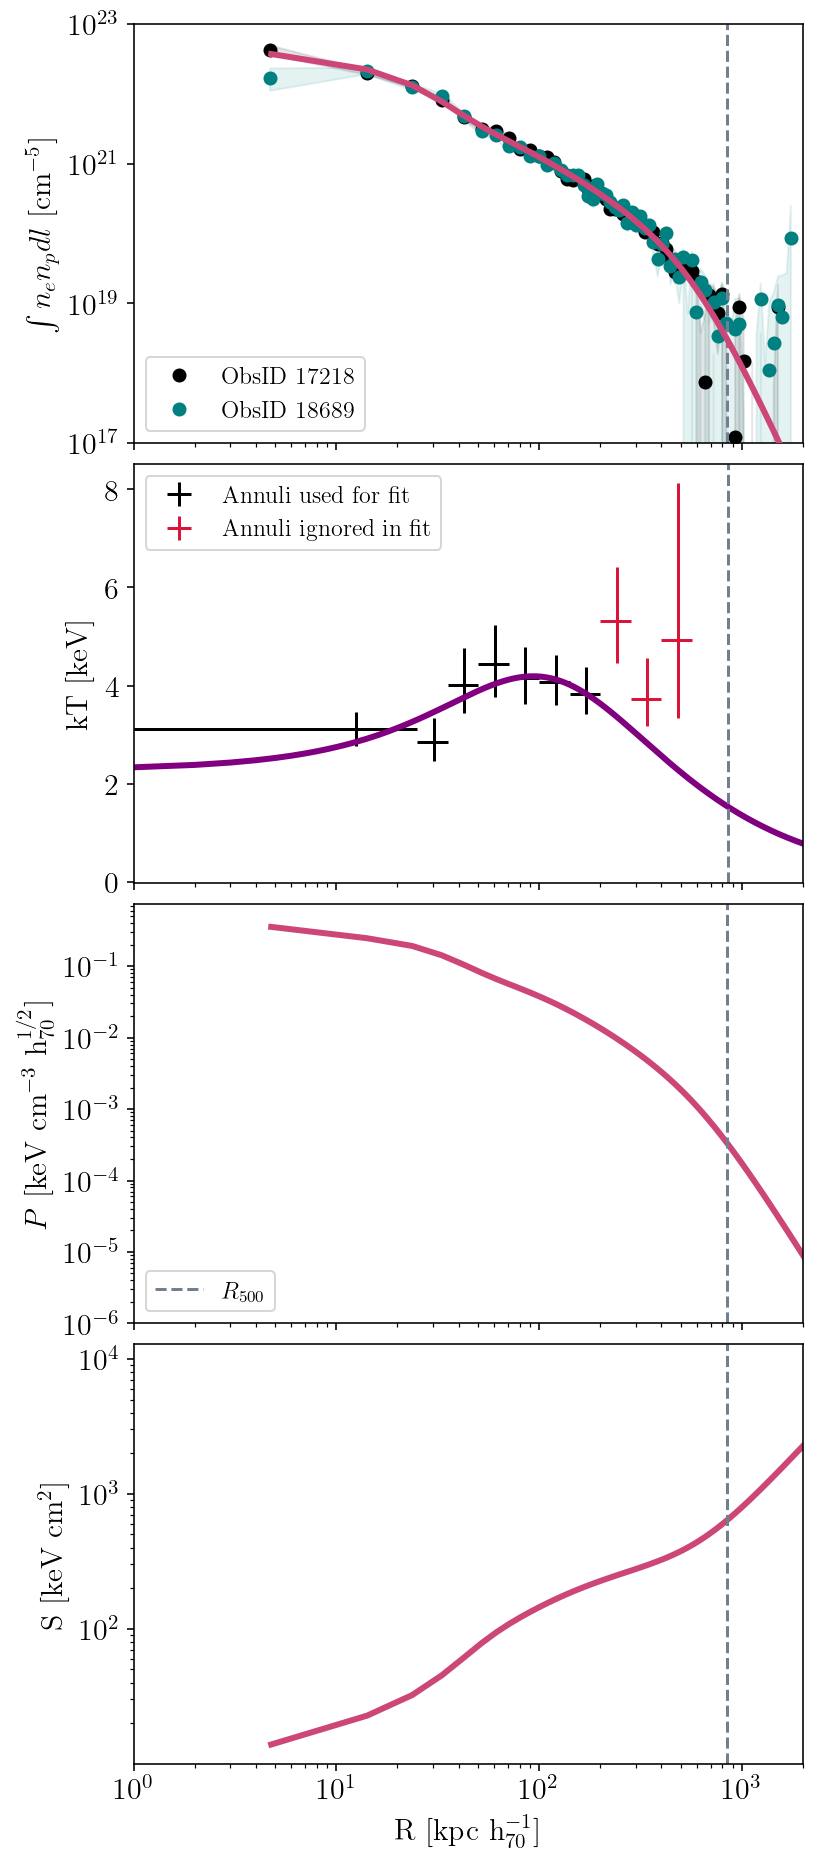

In [72]:
fig = plt.figure(figsize=(6, 16))
gs1 = GridSpec(4, 1)
gs1.update(hspace=0.05)


ax1 = fig.add_subplot(gs1[1])
ax1.errorbar(bin_center_radius_kpc[:last_fit_annulus], tprof['T(keV)'][:last_fit_annulus], 
                yerr=[-tprof['Terr-'][:last_fit_annulus], tprof['Terr+'][:last_fit_annulus]], 
                xerr=bin_center_radius_err_kpc[:last_fit_annulus], ls='none', 
                label='Annuli used for fit', color='k')
ax1.errorbar(bin_center_radius_kpc[last_fit_annulus:], tprof['T(keV)'][last_fit_annulus:], 
                yerr=[-tprof['Terr-'][last_fit_annulus:], tprof['Terr+'][last_fit_annulus:]], 
                xerr=bin_center_radius_err_kpc[last_fit_annulus:], ls='none', 
                label='Annuli ignored in fit', color='#dc143c')
ax1.plot(tfitx,tfity, color='purple', lw=3)
ax1.set_xlim(1,2000)
ax1.set_xscale('log')

ax1.axvline(r500, color='slategray', ls='--') # R_500 from the CCCPIV best fit. 

ax1.legend(fontsize=12)
ax1.set_ylabel('kT [keV]')
plt.setp(ax1.get_xticklabels(), visible=False)
# ax1.set_xlabel(r'R [kpc h$_{70}^{-1}$]')

#ax2

colors=['k', 'teal']
ax2=fig.add_subplot(gs1[0])

for i, profile in enumerate(profiles):

    x = c2etables[i]['R_KPC']
    y = (profile['SUR_BRI']  * c2etables[i]['C2EMM'] - sbprof_par_dict['bg']) / 9.52141e+42 # this factor is cm2 per kpc2
    err = (profile['SUR_BRI_ERR'] * c2etables[i]['C2EMM']) / 9.52141e+42

    #ax2.errorbar(x,y, yerr=err, ls='none', marker='o', label=obsids[i], color=colors[i])
    ax2.fill_between(x, y - err, y + err, color=colors[i], alpha = 0.1)
    ax2.plot(x, y, c = colors[i], ls='none', marker='o', label=obsids[i])

sb_fit_x = sb_profile_fit['R'] 
sb_fit_y = sb_profile_fit['FIT']/ 9.52141e+42

    
ax2.plot(sb_fit_x, sb_fit_y, lw=3, zorder=3, 
            color=sns.color_palette('plasma',1)[0])

plt.setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel(r'$\int n_e n_p dl$ [cm$^{-5}$]')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5) # R_500 from the CCCPIV best fit.
ax2.set_ylim(1e17,1e23)
ax2.set_xlim(ax1.get_xlim())
ax2.legend(fontsize=12)
#ax.set_title("Cluster X-ray Surface Brightness Profile \n")

# ax2.set_xlabel(r'R [kpc h$_{70}^{-1}$]')

#ax3

ax3 = fig.add_subplot(gs1[2])
ax3.plot(r, pressure_profile, color=sns.color_palette('plasma',1)[0], lw=3)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(1e-6)

ax3.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5, label=r'$R_{500}$') # R_500 from the CCCPIV best fit.
# ax.set_title(r'Pressure Profile ($nkT$)')
ax3.set_ylabel(r'$P$ [keV cm$^{-3}$ h$_{70}^{1/2}$]')

ax3.legend(fontsize=12)
ax3.set_xlim(ax1.get_xlim())
# ax3.set_xlabel(r'R [kpc h$_{70}^{-1}$]')
plt.setp(ax3.get_xticklabels(), visible=False)

#ax4
ax4 = fig.add_subplot(gs1[3])

ax4.plot(r, entropy_profile, color=sns.color_palette('plasma',1)[0], lw=3)

ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlim(0)
# ax.set_ylim(1, 10)

#ax.set_title(r'Entropy')

ax4.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5) # R_500 from the CCCPIV best fit.


ax4.set_xlabel(r'R [kpc h$_{70}^{-1}$]')
ax4.set_ylabel('S [keV cm$^2$]')
ax4.set_xlim(ax1.get_xlim())
# ax4.legend(fontsize=12)
# plt.setp(ax4.get_xticklabels(), visible=False)

fig.tight_layout()

fig.savefig(fig_path + 'chandra_tepe_profile.pdf')

In [64]:
ax3.get_ylim()

(1e-06, 0.7338193783484935)

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


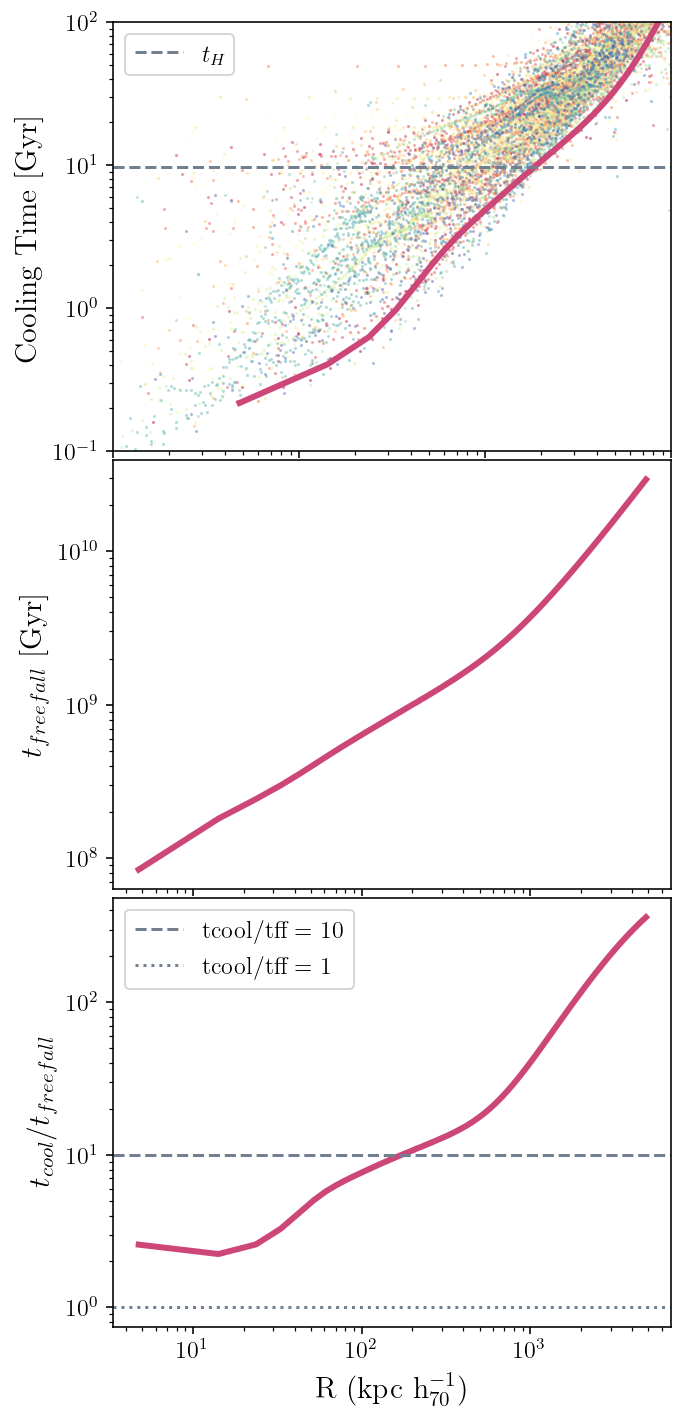

In [43]:
fig = plt.figure(figsize=(5, 12))
gs1 = GridSpec(3, 1)
gs1.update(hspace=0.02)



ax1 = fig.add_subplot(gs1[0])
ax1.plot(r, (cooling_time/ 3.156e+16)/1e9, zorder=2, lw=3, color=sns.color_palette('plasma',1)[0])


n = len(accept_table.groups.keys)
colors = sns.color_palette("Spectral", as_cmap=True)(np.linspace(0,1,n))

# underplot the cooling time profiles for all accept clusters as a comparison! 
for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    min_temperature = np.min(cluster_profile['Tx'])

    

    ax1.plot(accept_radius, cluster_profile['tcool3/2'], zorder=1, alpha=0.4, color=colors[i], lw=1, 
                linestyle='None', marker='o', markersize=0.6, rasterized=True)

#ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5) # R_500 from the CCCPIV best fit.
ax1.axhline(cosmo.age(z=0.335).value, color='slategray', ls='--', lw=1.5, label=r'$t_H$') # R_500 from the CCCPIV best fit.


ax1.set_yscale('log')
ax1.set_xscale('log')

ax1.set_xlim(1, 1000)
ax1.set_ylim(1e-1, 1e2)

ax1.legend(fontsize=12)
ax1.set_ylabel('Cooling Time [Gyr]')
plt.setp(ax1.get_xticklabels(), visible=False)
# ax1.set_xlabel(r'Radius (kpc h$_{70}^{-1}$)')

ax2 = fig.add_subplot(gs1[1])
ax2.loglog(sb_profile_fit['R'], t_freefall.to(u.yr), color=sns.color_palette('plasma',1)[0], lw=3)

ax2.set_ylabel(r'$t_{freefall}$ [Gyr]')
plt.setp(ax2.get_xticklabels(), visible=False)



ax3 = fig.add_subplot(gs1[2])
ax3.loglog(sb_profile_fit['R'], tcool_tff_ratio, color=sns.color_palette('plasma',1)[0], lw=3)
ax3.axhline(10,  color='slategray', ls='--', lw=1.5, label='tcool/tff = 10')
ax3.axhline(1,  color='slategray', ls=':', lw=1.5, label='tcool/tff = 1')

ax3.legend(fontsize=12)
ax3.set_ylabel(r'$t_{cool}/t_{freefall}$')
ax3.set_xlabel(r'R (kpc h$_{70}^{-1}$)')

fig.tight_layout()

fig.savefig(fig_path + 'chandra_tcool_profile.pdf')

In [110]:
((cooling_time/ 3.156e+16)/1e9)[6]

2.6346545671002017

In [106]:

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass']

mcool = y/(cooling_time/ 3.156e+16)

In [113]:
(10**(10)/mcool[6])/1e6

53.593461495122085

In [118]:
4.928 * kpc_per_arcsec

<Quantity 23.65318595 kpc / arcsec>

In [128]:
(((cooling_time[3]/ 3.156e+16) * u.yr)/((30 * u.kpc)/(200 * (u.km/u.s)))).cgs

<Quantity 6.65642989>

In [122]:
x[3]

33.06

In [143]:
((7827/7862) - 1) * const.c + (((7881/7862) - 1) * const.c)

<Quantity -610109.30144999 m / s>

In [140]:
((7795/7794) - 1) * const.c

<Quantity 38464.51860403 m / s>